# Configuration models and synthetic networks
In order to understand the significance of our network's topology we built two synthetic models which have the same properties as our network. We kept the degree distribution, number of zealots and their ratios (number of blacklisted / whitelisted nodes). The model has the following configurations: 

<b>Randomly shuffled links:</b> We kept the nodes susceptibility and labels as in the original network but we shuffled the links at random keeping the degree distribution of each node.

Then we run our configuration of the voter model on a projected network. We ran $m=50$ realizations of the voter model and plot the relative number of changes. Then we choosed 3/10ths as a testing set, compute the confusion matrix, ROC curve and total accuracy.

In [1]:
import voter_model as vm
from kassiopea import Kassiopea
from tools import plot_roc, plot_pdf, round_acc, round_acc2

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import random as r
import time
import csv

In [2]:
def random_edges(edge_list, A, B, i, j):
    if (A[i], B[j]) not in edge_list:
        edge_list.append((A[i], B[j]))
        del A[i]
        del B[j]
    return edge_list

In [3]:
start = time.time()
K = Kassiopea()

# Statistics of initial states counts
blacklisted = 0
whitelisted = 0
uknown = 0

IPs = []
dns = []

# Add network's nodes and edges from file
with open("data/data.csv") as csvfile: 
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Create domain's nodes
        if row["domain"] not in K.get_nodes():
            label = int(row["domain_state"])
            if label == 0:
                zea = 1
                label = 0
                uknown += 1
            else:
                zea = 0
                if label == 1:
                    whitelisted += 1
                else:
                    blacklisted += 1
                    
            K.add_node(row['domain'], zea=zea, label=label)
        
        # Create ip's nodes 
        if row["ip"] not in K.get_nodes():
            label = int(row["ip_state"])
            if label == 0:
                zea = 1
                uknown += 1
            else:
                zea = 0
                if label == 1:
                    whitelisted += 1
                else:
                    blacklisted += 1
    
            K.add_node(row["ip"], zea=zea, label=label)
        
        # Create an edge between IP <-> Domain
        IPs.append(row["ip"])
        dns.append(row["domain"])
        
print(f"Network is created in: {round(time.time() - start, 3)}s")

Network is created in: 279.76s


In [6]:
r.shuffle(IPs)
r.shuffle(dns)
edge_list = [(IPs[i], dns[i]) for i, n in enumerate(IPs)]
for e in edge_list:
    K.add_edge(e[1], e[0])
    
# As the original labels and zeas will be changed, we deepcopy them 
original_labels = deepcopy(K.label)
original_zeas = deepcopy(K.zea)

# Selecting the zeas from the dataset
zeas = [i for i, v in enumerate(original_zeas) if v == 0]
num_zeas = len(zeas)

In [8]:
# Statistics of final states counts
blacklisted_f = 0
whitelisted_f = 0
unknown_f = 0
    
rate = {}
num_nodes = len(K.get_nodes())
stopping_time = []

# Num of realisation of Voter Model
m = 50

# Fraction size of the trainning data set
accs = 3 / 10
num_ch = int(num_zeas * accs)
random_z = r.sample(zeas, num_ch)

# Set the lables to original labels
K.update_label(original_labels)
K.update_zea(original_zeas)

# Trainning zeas are labeled as unknown
for n in random_z:
    K.update_zea_node(n, 1)
    K.update_label_node(n, 0)

# Deepcopy current labels with trainning zeas
labels = deepcopy(K.label)
rate = [0] * num_nodes    

# Running m independent realisation of Voter Model
for i in range(m):
    # Set the labels to original ones
    K.update_label(labels)
    stop = time.time()
    hist,x, st, u = vm.voter_model_realisation(K)
    print(f"Time used for this realization: {round(time.time() - stop, 3)}s realization: {i + 1} / {m}")
    
    # Assign rate for later computing of longterm average
    for n in range(num_nodes):
        rate[n] += int(K.label[n])

Time used for this realization: 6.014s realization: 1 / 50
Time used for this realization: 6.643s realization: 2 / 50
Time used for this realization: 6.387s realization: 3 / 50
Time used for this realization: 6.669s realization: 4 / 50
Time used for this realization: 6.637s realization: 5 / 50
Time used for this realization: 6.445s realization: 6 / 50
Time used for this realization: 6.58s realization: 7 / 50
Time used for this realization: 6.5s realization: 8 / 50
Time used for this realization: 8.073s realization: 9 / 50
Time used for this realization: 6.642s realization: 10 / 50
Time used for this realization: 6.793s realization: 11 / 50
Time used for this realization: 6.687s realization: 12 / 50
Time used for this realization: 6.437s realization: 13 / 50
Time used for this realization: 6.84s realization: 14 / 50
Time used for this realization: 6.473s realization: 15 / 50
Time used for this realization: 6.74s realization: 16 / 50
Time used for this realization: 6.756s realization: 17

After m realisations are run we can make some statistics and take a look on accuracy. Under confustion matrix we understand: 
$$\begin{bmatrix}
    TrueWhitelisted & FlaseWhitelisted \\
    FalseBlacklisted & TrueBlacklisted \\
\end{bmatrix}$$

In [10]:
# Confusion matrix
confusion_matrix = np.zeros((2, 2))

def round_1(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0
    
for n in random_z: 
    if original_labels[n] == round_1(rate[n]):
        if original_labels[n] == 1:
            confusion_matrix[0][0] += 1
        else:
            confusion_matrix[1][1] += 1
    else:
        if original_labels[n] == 1:
            confusion_matrix[0][1] += 1
        else:
            confusion_matrix[1][0] += 1
            
print("Confusion matrix, relative numbers")  
print(confusion_matrix[0] / (confusion_matrix[0][1] + confusion_matrix[0][0]))
print(confusion_matrix[1] / (confusion_matrix[1][1] + confusion_matrix[1][0]), "\n")
print("Confusion matrix, absolute numbers")
print(confusion_matrix)

print("Accuracy:", round((confusion_matrix[0][0] + confusion_matrix[1][1]) / len(random_z), 3), "%\n")

blacklisted_f = 0
whitelisted_f = 0
unknown_f = 0

for n in range(num_nodes):
    if (rate[n] / m) < 0:
        blacklisted_f += 1
    elif (rate[n] / m) > 0:
        whitelisted_f += 1
    else:
        unknown_f += 1
        
print("Statistics about states")
print(f"#Uknown: (before, after): {(unknown_f, unknown)}")
print(f"#Whitelisted: (before, after): {(whitelisted_f, whitelisted)}")
print(f"#Blacklisted: (before, after): {(blacklisted_f, blacklisted)}\n")

print(f"Ratio whitelisted / blacklisted in the end: {round(whitelisted_f / blacklisted_f, 3)}")
print(f"Ratio whitelisted / blacklisted in the beginning: {round(whitelisted / blacklisted, 3)}")
print(f"#nodes: {len(K.get_nodes())}")
print(f"#edges: {len(K.get_edges())}")

Confusion matrix, relative numbers
[0.25123153 0.74876847]
[0.34666667 0.65333333] 

Confusion matrix, absolute numbers
[[ 51. 152.]
 [260. 490.]]
Accuracy: 0.568 %

Statistics about states
#Uknown: (before, after): (8210, 93674)
#Whitelisted: (before, after): (25316, 643)
#Blacklisted: (before, after): (63327, 2536)

Ratio whitelisted / blacklisted in the end: 0.4
Ratio whitelisted / blacklisted in the beginning: 0.254
#nodes: 96853
#edges: 137289


In this section, we would like to present ROC curve and comparison between rate, eigenvalue centrality, degree distibution

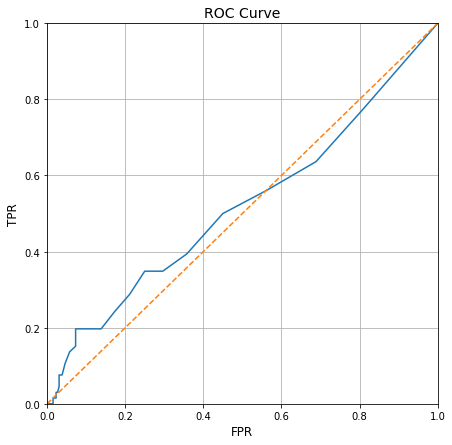

In [11]:
l = 50 
wl = [(rate[n] / m) for n in random_z if original_labels[n] == 1]
bl = [(rate[n] / m) for n in random_z if original_labels[n] == -1]

hist_wl, bins = np.histogram(wl, bins=np.linspace(0, 1, l + 1), density=True)
hist_bl, bins = np.histogram(bl, bins=np.linspace(0, 1, l + 1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_roc(hist_bl, hist_wl, ax, np.arange(0, l))
plt.show()

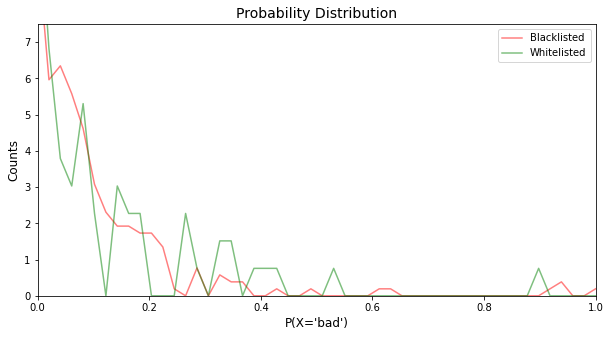

In [13]:
x = np.linspace(0, 1, num=l)
    
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot_pdf(hist_bl, hist_wl, ax, x)
plt.show()

### Sources:
[1] Receiver Operating Characteristic Curves Demystified (in Python), https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0